<a href="https://colab.research.google.com/github/jai2shan/TSAI-EVA40-Assignments/blob/master/Session%2010/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jai2shan/TSAI-EVA40-Assignments.git
import os
os.chdir(r'/content/TSAI-EVA40-Assignments/Session 10/asgnmt10')

Cloning into 'TSAI-EVA40-Assignments'...
remote: Enumerating objects: 290, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (238/238), done.
remote: Total 722 (delta 150), reused 128 (delta 40), pack-reused 432
Receiving objects: 100% (722/722), 24.81 MiB | 9.26 MiB/s, done.
Resolving deltas: 100% (374/374), done.


In [0]:
from torchvision import transforms
from DataLoader import cifar_data_loader,View_images
from cutout import *
import torch
from torchsummary import summary
from resnet import ResNet18

from LR_Finder import *
from Training_Testing import TrainTest
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from ModelPerformance import *
from gradcam import GradCamDisplay
import PIL
from gradcam import *
import copy

In [3]:
transform_params = dict()
transform_params['train'] = transforms.Compose([
                                       transforms.RandomRotation(10),
                                       transforms.RandomHorizontalFlip(),  
                                       transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),  
                                       transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
                                       transforms.ToTensor(),
                                       Cutout(n_holes=1, length=16,prob = 0.5),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

transform_params['test'] = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader,testloader = cifar_data_loader(transform_params,BatchSize=250)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

net = ResNet18().to(device)
summary(net, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,


Learning rate search finished. See the graph with {finder_name}.plot()


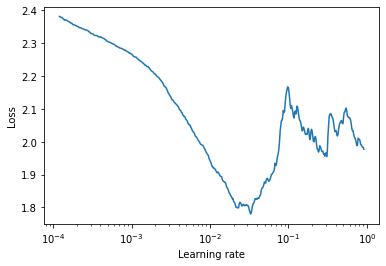

In [5]:
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

lr_finder = LRFinder(net, optimizer, criterion)
lr_finder.range_test(trainloader, end_lr=1, num_iter=500,step_mode="exp")
lr_finder.plot()

In [6]:
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9,weight_decay = 0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

for epoch in range(40):
    print("EPOCH:", epoch)
    tt.train_(net, device, trainloader, optimizer, criterion, epoch,L1 = False)
    acc = tt.test_(net, device, testloader)  
    scheduler.step(tt.test_losses[epoch])
       
print('Finished Training')

  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.3032045364379883 Batch_id=199 Accuracy=48.06: 100%|██████████| 200/200 [04:02<00:00,  1.21s/it]


TypeError: ignored

In [0]:
scheduler.step(tt.test_losses[epoch])

In [8]:
acc = tt.test_(net, device, testloader)


Test set: Average loss: -3.5347, Accuracy: 5692/10000 (56.92%)

